# Maximization bias

In this excercise, we will see maximization bias in practice. We will have a chance to mitigate this effect.

## Goal:

- understanding effects from maximization bias
- how to mitigate this effect

In [1]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: A toy env

This environment is hand-crafted to show the effect of maximization bias.

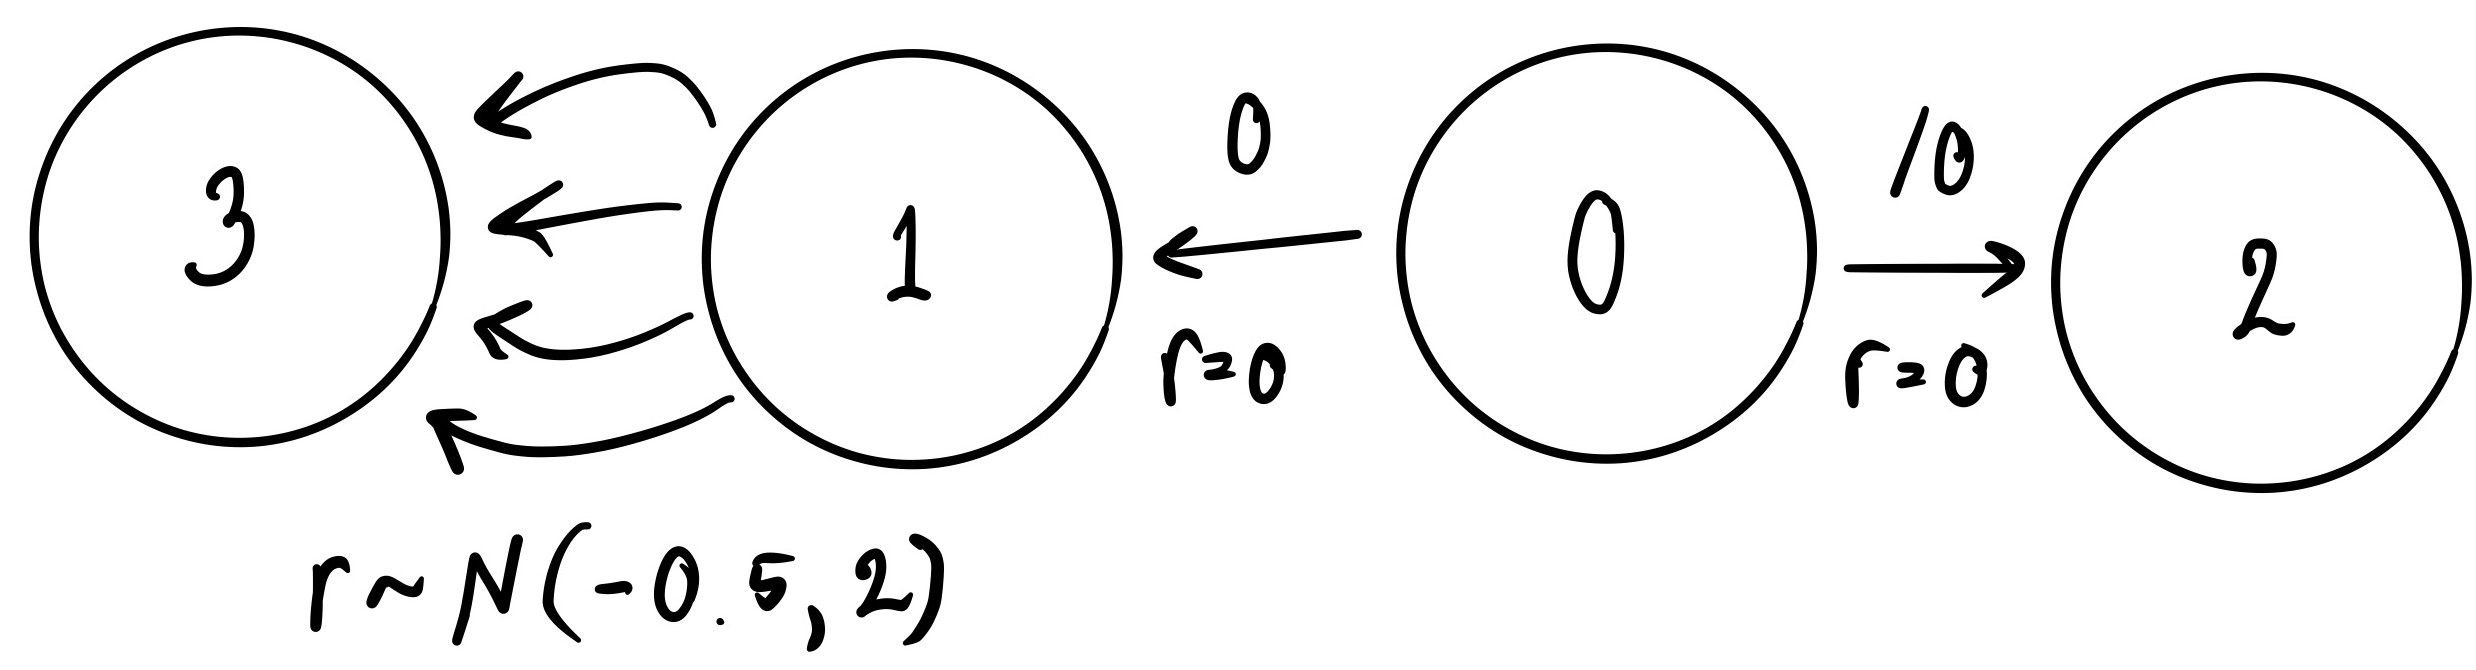

In [2]:
class ToyEnv(gym.Env):
    """n_action, the larger the number the larger the effect"""
    def __init__(self, n_action, use_random=True):
        self.use_random = use_random
        self.s = None
        self.observation_space = gym.spaces.Discrete(4)
        self.action_space = gym.spaces.Discrete(n_action)
    
    def reset(self):
        self.s = 0
        return self.s
    
    def step(self, action):
        if self.s == 0:
            if action == 0:
                s = 1
                r = 0.0
                done = False
            else: 
                s = 2
                r = 0.0
                done = True
        elif self.s == 1:
            s = 3
            if self.use_random: 
                r = np.random.randn() * 2 - 0.5
            else:
                r = -0.5
            done = True
        self.s = s
        return s, r, done, {}

def make_env():
    env = ToyEnv(100, True)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env

def make_deterministic_env():
    env = ToyEnv(100, False)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env

env = make_env()

## Step 2: Define policy

### 2.1 Q-learning 

In [44]:
class QlearningPolicy(rl.policy.BasePolicy):
    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        self.q = np.zeros([observation_space.n, n_action])

    def step(self, state):
        # code here ...
        return np.argmax(self.q[state])

    def optimize_step(self, data):
        s, a, r, ss, done = data['s'], data['a'], data['r'], data['ss'], data[
            'done']
        sa = (s, a)
        # code here ...
        current_state = (s,a)
        next_action = self.step(ss)
        next_state = (ss,next_action)
        self.q[current_state] = self.q[current_state] + self.lr*(r + self.discount_factor*self.q[next_state] - self.q[current_state])




### 2.2 SARSA

You could copy from previous works.

In [45]:
class SARSAPolicy(rl.policy.BasePolicy):
    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        self.q = np.zeros([observation_space.n, n_action])

    def step(self, state):
        # code here ...
        #print(state)
        return np.argmax(self.q[state])

    def optimize_step(self, data):
        # evaluation (prediction)
        s, a, r, ss, aa, done = data['s'], data['a'], data['r'], data[
            'ss'], data['aa'], data['done']
        sa = (s, a)
        ssaa = (ss, aa)
        # code here ...
        s = data['s']
        a = data['a']
        r = data['r']
        ss = data['ss']
        aa = data['aa']
        s0 = (s,a)
        s1 = (ss,aa)
        #print('hi')
        #print(s0,r,s1)
        #print(self.q[s0] + self.discount_factor*(r+self.q[s1]))
        self.q[s0] = self.q[s0] + self.lr*(r+self.discount_factor*self.q[s1]-self.q[s0])
        #print(self.q)

### 2.3 MC

You could copy from previous works. 

Note: this is first-visit constant learning rate Monte Carlo.

In [128]:
def calculate_return(r, discount_factor):
    """return G for every time step given a sequence of rewards"""
    # code here ...
    g = []
    for i in range(len(r)):
        s = 0
        for j in range(i,len(r)):
            s+=r[j]*discount_factor**(j-i)
        g.append(s)
    g = np.array(g)
    return g

def first_sa(s, a, g):
    """deduplicate (s, a) keeping only the first occurrances while also matching the corresponding returns"""
    # code here ...
    sa = [[],[]]
    have_state = set()
    count = 0
    gi = []
    for si in s:
        if(si not in have_state):
            sa[0].append(si)
            sa[1].append(a[count])
            gi.append(g[count])
            have_state.add(si)
        count+=1
    # return unique sa and g
    # sa = tuple(first dim of s, second dim of s, a)
    # this is for numpy indexing!
    # ex: sa = ([0, 0], [0, 1], [1, 1])
    # means: s = [(0, 0), (0, 1)]; a = [1, 1]
    for i in range(len(sa)):
        sa[i] = np.array(sa[i])
    sa = tuple(sa)
    gi = np.array(gi)
    return sa, gi


class MonteCarloPolicy(rl.policy.BasePolicy):
    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        self.q = np.zeros([observation_space.n, n_action])

    def step(self, state):
        #print(np.argmax(self.q[tuple(state)]))
        #print(state)
        return np.argmax(self.q[state])  # greedy action selection

    def optimize_step(self, data):
        # code here ...
        s = np.array(data['s'])
        a = np.array(data['a'])
        r = np.array(data['r'])
        sa,gi = first_sa(s,a,r)
        #print(sa)
        #Gs = []
        for i in range(sa[0].shape[0]):
            current_s = sa[0][i]
            current_a = sa[1][i]
            g = np.mean(calculate_return(gi[i:],self.discount_factor))
            #print(current_s,current_a)
            self.q[current_s][current_a] = g
        #print(self.q)
        return 0


## Run experiments

We have implemented a `trainer` for you. Hopefully, this will do away the need of writing a traning loop.

You could look into the `trainer.py` if you wish.

In [124]:
def run(make_env, policy_cls, explorer_cls, seed=0):
    rl.util.set_seed(seed)
    policy = policy_cls(0.1, 0.99, env.observation_space, env.action_space.n)
    policy = rl.policy.wrapper.EpsilonGreedy(policy, eps=0.1, n_action=env.action_space.n)
    # note: train function is a fancy training loop extendable and ready to use.
    df = rl.trainer.train(
        explorer_cls(1000, make_env()), 
        policy,
        make_env,
        callbacks=[
            # every 10 interactions, evaluate the policy performance for 100 interactions
            rl.trainer.EvalCb(10, 100),
        ]
    )
    return df

### Run SARSA

1001it [00:00, 3460.97it/s]                                                                                            


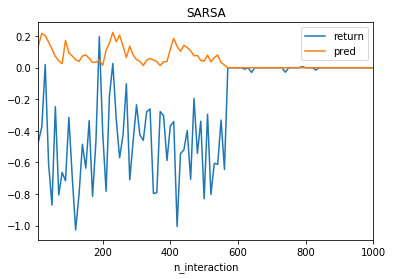

In [125]:
# run the policy
df = run(make_env, SARSAPolicy, rl.explorer.OneStepExplorer, seed=0)

# see the result
ax = plt.subplot()
ax.set_title('SARSA')
df.plot('n_interaction', 'eval_return', ax=ax)
df.plot('n_interaction', 'eval_return_pred', ax=ax)
ax.legend(['return', 'pred'])

Expected result: 

You should see two-phases: 

1. It consistently over-estimates the q value
2. It converges to the correct q value

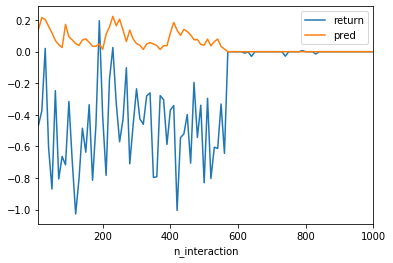

### Run Q-learning

1001it [00:00, 3703.62it/s]                                                                                            


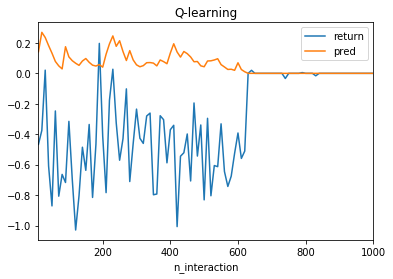

In [126]:
# run the policy
df = run(make_env, QlearningPolicy, rl.explorer.OneStepExplorer, seed=0)

# see the result
ax = plt.subplot()
ax.set_title('Q-learning')
df.plot('n_interaction', 'eval_return', ax=ax)
df.plot('n_interaction', 'eval_return_pred', ax=ax)
ax.legend(['return', 'pred'])

Expected result: very close to that of SARSA. Maximization bias is present.

### Run MC

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3084.87it/s]


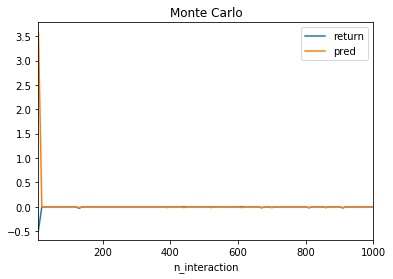

In [129]:
# run the policy
df = run(make_env, MonteCarloPolicy, rl.explorer.EpisodeExplorer, seed=0)

# see the result
ax = plt.subplot()
ax.set_title('Monte Carlo')
df.plot('n_interaction', 'eval_return', ax=ax)
df.plot('n_interaction', 'eval_return_pred', ax=ax)
ax.legend(['return', 'pred'])

Expeceted result: Monte Carlo should not have the maximization bias. It converges very fast.

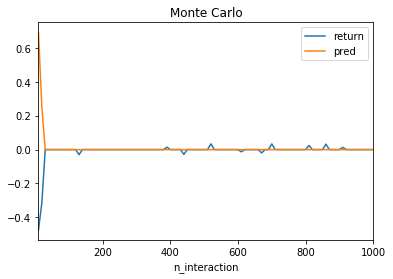

# Q1: What happens to the maximization bias if we increase/decrease the number of actions at the state 1? 

bias จะเพิ่มขึ้นถ้ามี action ใน state 1 ที่เพิ่มขึ้น

# Mitigating the maximization bias with double estimator

## Step 2: Define policy (Double Q Learning)

In [136]:
from random import randrange
class DoubleQlearningPolicy(rl.policy.BasePolicy):
    """Q-learning with double estimator"""
    
    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        self.q = np.zeros([observation_space.n, n_action])
        self.q2 = np.zeros([observation_space.n, n_action])

    def step(self,state):
        # code here ...
        sum_q = self.q + self.q2
        return np.argmax(sum_q[state])

    def optimize_step(self, data):
        s, a, r, ss, done = data['s'], data['a'], data['r'], data['ss'], data[
            'done']
        sa = (s, a)
        choose = randrange(2)
        # code here ...
        if(choose == 0):#update 1
            next_action = np.argmax(self.q[ss])
            self.q[s][a] = self.q[s][a] + self.lr*(r + self.discount_factor*np.max(self.q2[ss][next_action] - self.q[s][a]))
        elif(choose == 1):#update 2
            next_action = np.argmax(self.q2[ss])
            self.q2[s][a] = self.q2[s][a] + self.lr*(r + self.discount_factor*np.max(self.q[ss][next_action] - self.q2[s][a]))
        else:
            print("error!!")


### Run Q-learning vs Double Q-learning

The result varies so much across runs. We hence average the results across many runs (10 runs).

In [137]:
single = [run(make_env, QlearningPolicy, rl.explorer.OneStepExplorer, seed=i) for i in range(10)]

1001it [00:00, 3745.07it/s]                                                                                            
1001it [00:00, 3801.78it/s]                                                                                            
1001it [00:00, 3951.51it/s]                                                                                            
1001it [00:00, 3703.62it/s]                                                                                            
1001it [00:00, 3745.22it/s]                                                                                            
1001it [00:00, 3830.84it/s]                                                                                            
1001it [00:00, 4014.72it/s]                                                                                            
1001it [00:00, 3890.23it/s]                                                                                            
1001it [00:00, 3830.85it/s]             

In [138]:
double = [run(make_env, DoubleQlearningPolicy, rl.explorer.OneStepExplorer, seed=i) for i in range(10)]

1001it [00:00, 2996.07it/s]                                                                                            
1001it [00:00, 3060.01it/s]                                                                                            
1001it [00:00, 3041.46it/s]                                                                                            
1001it [00:00, 3014.05it/s]                                                                                            
1001it [00:00, 2987.14it/s]                                                                                            
1001it [00:00, 3060.00it/s]                                                                                            
1001it [00:00, 3005.03it/s]                                                                                            
1001it [00:00, 3087.98it/s]                                                                                            
1001it [00:00, 3088.26it/s]             

### Comparing prediction value (q-value)

We plot the mean + std to give a better idea about the result.

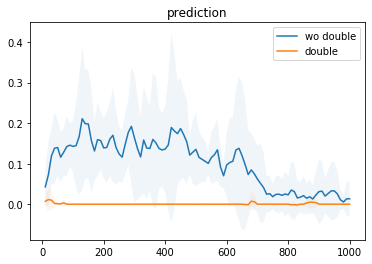

In [139]:
ax = plt.subplot()
ax.set_title('prediction')
rl.util.plot_std(ax, pd.concat(single).groupby('n_interaction'), 'eval_return_pred')
rl.util.plot_std(ax, pd.concat(double).groupby('n_interaction'), 'eval_return_pred')
ax.legend(['wo double', 'double'])

Expected result: Double Q-learning has much less maximization bias.

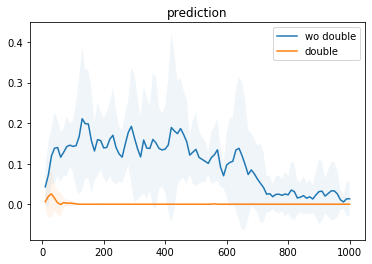

### Comparing total reward

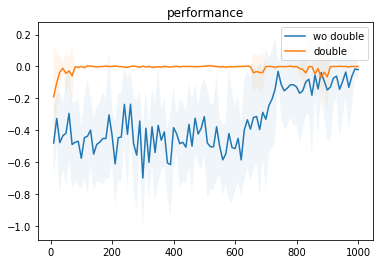

In [140]:
ax = plt.subplot()
ax.set_title('performance')
rl.util.plot_std(ax, pd.concat(single).groupby('n_interaction'), 'eval_reward')
rl.util.plot_std(ax, pd.concat(double).groupby('n_interaction'), 'eval_reward')
ax.legend(['wo double', 'double'])

Expected result: Of course, the double version learns better policy much faster.

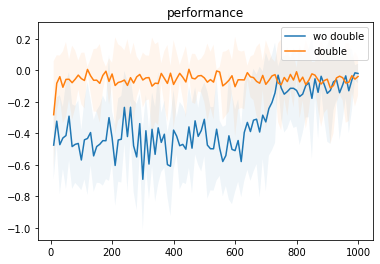